
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, label_binarize, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [3]:
X = ha.drop("cp", axis = 1)
y = ha["cp"]

In [4]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

knn = Pipeline(
  [("preprocessing", ct),
  ("knn", KNeighborsClassifier())]
).set_output(transform="pandas")

# 1. Cross-Validation for KNN
#For KNN we definetely need to standardize!
knn_scores = cross_val_score(knn, X, y, cv=5, scoring='roc_auc_ovo').mean()
print(knn_scores)

0.5775534607005195


In [5]:
#Question: What do we put inside the decision tree function?
# Decision Tree
decision_tree = Pipeline((
  [#("preprocessing", ct),
  ("tree", DecisionTreeClassifier(max_depth = 2))]
))

dt_scores = cross_val_score(decision_tree, X, y, cv=5, scoring='roc_auc_ovo').mean()
print(dt_scores)

0.607999937154349


In [6]:
# LDA
lda = Pipeline(
  [("preprocessing", ct),
  ("lda", LinearDiscriminantAnalysis())]
).set_output(transform="pandas")
lda_scores = cross_val_score(lda, X, y, cv=5, scoring='roc_auc_ovo').mean()
print(lda_scores)

0.6652907920646892


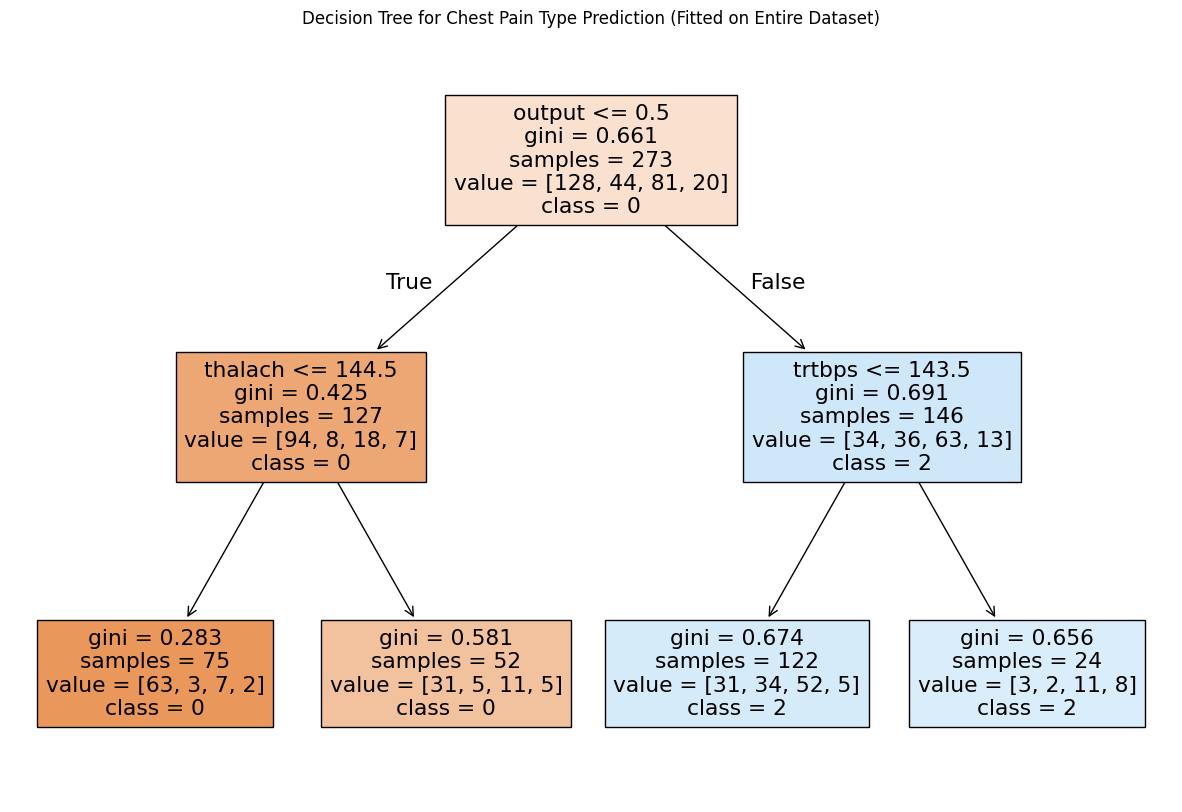

In [7]:
# Fit the decision tree on the entire dataset for visualization
decision_tree.fit(X, y)

# Access the fitted DecisionTreeClassifier
tree_model = decision_tree.named_steps['tree']

plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=["0", "1", "2", "3"], filled=True)  # Use tree_model here
plt.title("Decision Tree for Chest Pain Type Prediction (Fitted on Entire Dataset)")
plt.show()

Interpret the first couple splits:
The decision tree begins by splitting on output <= 0.5, dividing the 273 samples into two branches. The left branch, where output <= 0.5 is true, contains 127 samples with a Gini index of 0.425 and is dominated by Class 0 (94 samples). This branch further splits on thalach <= 144.5, creating two nodes: the left child has 75 samples (majority Class 0, Gini = 0.283), while the right child has 52 samples (still majority Class 0 but with more impurity, Gini = 0.581). The right branch of the root node, where output > 0.5, contains 146 samples with a higher Gini index of 0.691 and is dominated by Class 2 (63 samples). This branch splits on trtbps <= 143.5, producing two child nodes: the left child has 122 samples (majority Class 2, Gini = 0.674), and the right child has 24 samples (majority Class 2, Gini = 0.656). Each split reduces impurity and refines the predictions for the majority class.

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [8]:
#Question: Do we need to dummify or standardize anymore?
#New column
ha["cp_is_3"] = ha['cp'] == 3
ha["cp_is_3"] = ha["cp_is_3"].astype(int)

X = ha.drop(columns=["cp_is_3", "cp"])
y = ha["cp_is_3"]

#Question: What goes inside the logistic regression function?
#Fit a logistic regression

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

logreg_pipeline1 = Pipeline(
  [("preprocessing", ct),
  ("logreg", LogisticRegression(max_iter=1000))]
).set_output(transform="pandas")


#f1 score???
y_pred = cross_val_predict(logreg_pipeline1, X, y, cv=5)
f1_cp3 = f1_score(y, y_pred)
print("cp3:",f1_cp3)

#repeat for the other three cp categories
#When cp is 0
ha["cp_is_0"] = ha['cp'] == 0
ha["cp_is_0"] = ha["cp_is_0"].astype(int)

X = ha.drop(columns=["cp_is_0", "cp_is_3", "cp"])
y = ha["cp_is_0"]

y_pred = cross_val_predict(logreg_pipeline1, X, y, cv=5)
f1_cp0 = f1_score(y, y_pred)
print("cp0:", f1_cp0)

#When cp is 1
ha["cp_is_1"] = ha['cp'] == 1
ha["cp_is_1"] = ha["cp_is_1"].astype(int)

X = ha.drop(columns=["cp_is_1", "cp_is_0", "cp_is_3", "cp"])
y = ha["cp_is_1"]

y_pred = cross_val_predict(logreg_pipeline1, X, y, cv=5)
f1_cp1 = f1_score(y, y_pred)
print("cp1:",f1_cp1)

#When cp is 2
ha["cp_is_2"] = ha['cp'] == 2
ha["cp_is_2"] = ha["cp_is_2"].astype(int)

X = ha.drop(columns=["cp_is_2", "cp_is_1", "cp_is_0", "cp_is_3", "cp"])
y = ha["cp_is_2"]

y_pred = cross_val_predict(logreg_pipeline1, X, y, cv=5)
f1_cp2 = f1_score(y, y_pred)
print("cp2:",f1_cp2)


cp3: 0.0
cp0: 0.7159533073929961
cp1: 0.0
cp2: 0.2127659574468085


OvR was best at distinguishing between a chest pain score of 3 or not a score of 3 as it had the highest F1 score.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [9]:
#Reduce dataset to only the 0 and 1 types of chest pain
filtered_ha = ha[ha['cp'].isin([0, 1])]
filtered_ha.head()

X = filtered_ha.drop(columns=["cp", 'cp_is_3', 'cp_is_0', 'cp_is_1', "cp_is_2"])
y = filtered_ha["cp"]

#Fit a logistic regression

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

logreg_pipeline1 = Pipeline(
  [("preprocessing", ct),
  ("logreg", LogisticRegression(max_iter=1000))]
).set_output(transform="pandas")

logreg_score = cross_val_score(logreg_pipeline1, X, y, cv=5, scoring='roc_auc').mean()
print(logreg_score)

0.8376709401709401


In [10]:
#Reduce dataset to only the 0 and 2 types of chest pain
filtered_ha = ha[ha['cp'].isin([0, 2])]
filtered_ha.head()

X = filtered_ha.drop(columns=["cp", 'cp_is_3', 'cp_is_0', 'cp_is_1', "cp_is_2"])
y = filtered_ha["cp"]

#Fit a logistic regression

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

logreg_pipeline1 = Pipeline(
  [("preprocessing", ct),
  ("logreg", LogisticRegression(max_iter=1000))]
).set_output(transform="pandas")

logreg_score = cross_val_score(logreg_pipeline1, X, y, cv=5, scoring='roc_auc').mean()
print(logreg_score)

0.7511029411764706


In [11]:
#Reduce dataset to only the 0 and 3 types of chest pain
filtered_ha = ha[ha['cp'].isin([0, 3])]
filtered_ha.head()

X = filtered_ha.drop(columns=["cp", 'cp_is_3', 'cp_is_0', 'cp_is_1', "cp_is_2"])
y = filtered_ha["cp"]

#Fit a logistic regression

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

logreg_pipeline1 = Pipeline(
  [("preprocessing", ct),
  ("logreg", LogisticRegression(max_iter=1000))]
).set_output(transform="pandas")

logreg_score = cross_val_score(logreg_pipeline1, X, y, cv=5, scoring='roc_auc').mean()
print(logreg_score)

0.7412307692307692


The OvO score was best at predicting between a chest pain of 0 and 1 as it had the highest roc auc score.

F1 score says am I good at finding the target category?
Roc Auc says how confident am I at distinguishing two things (chest pain of 1 from chest pain of 0)